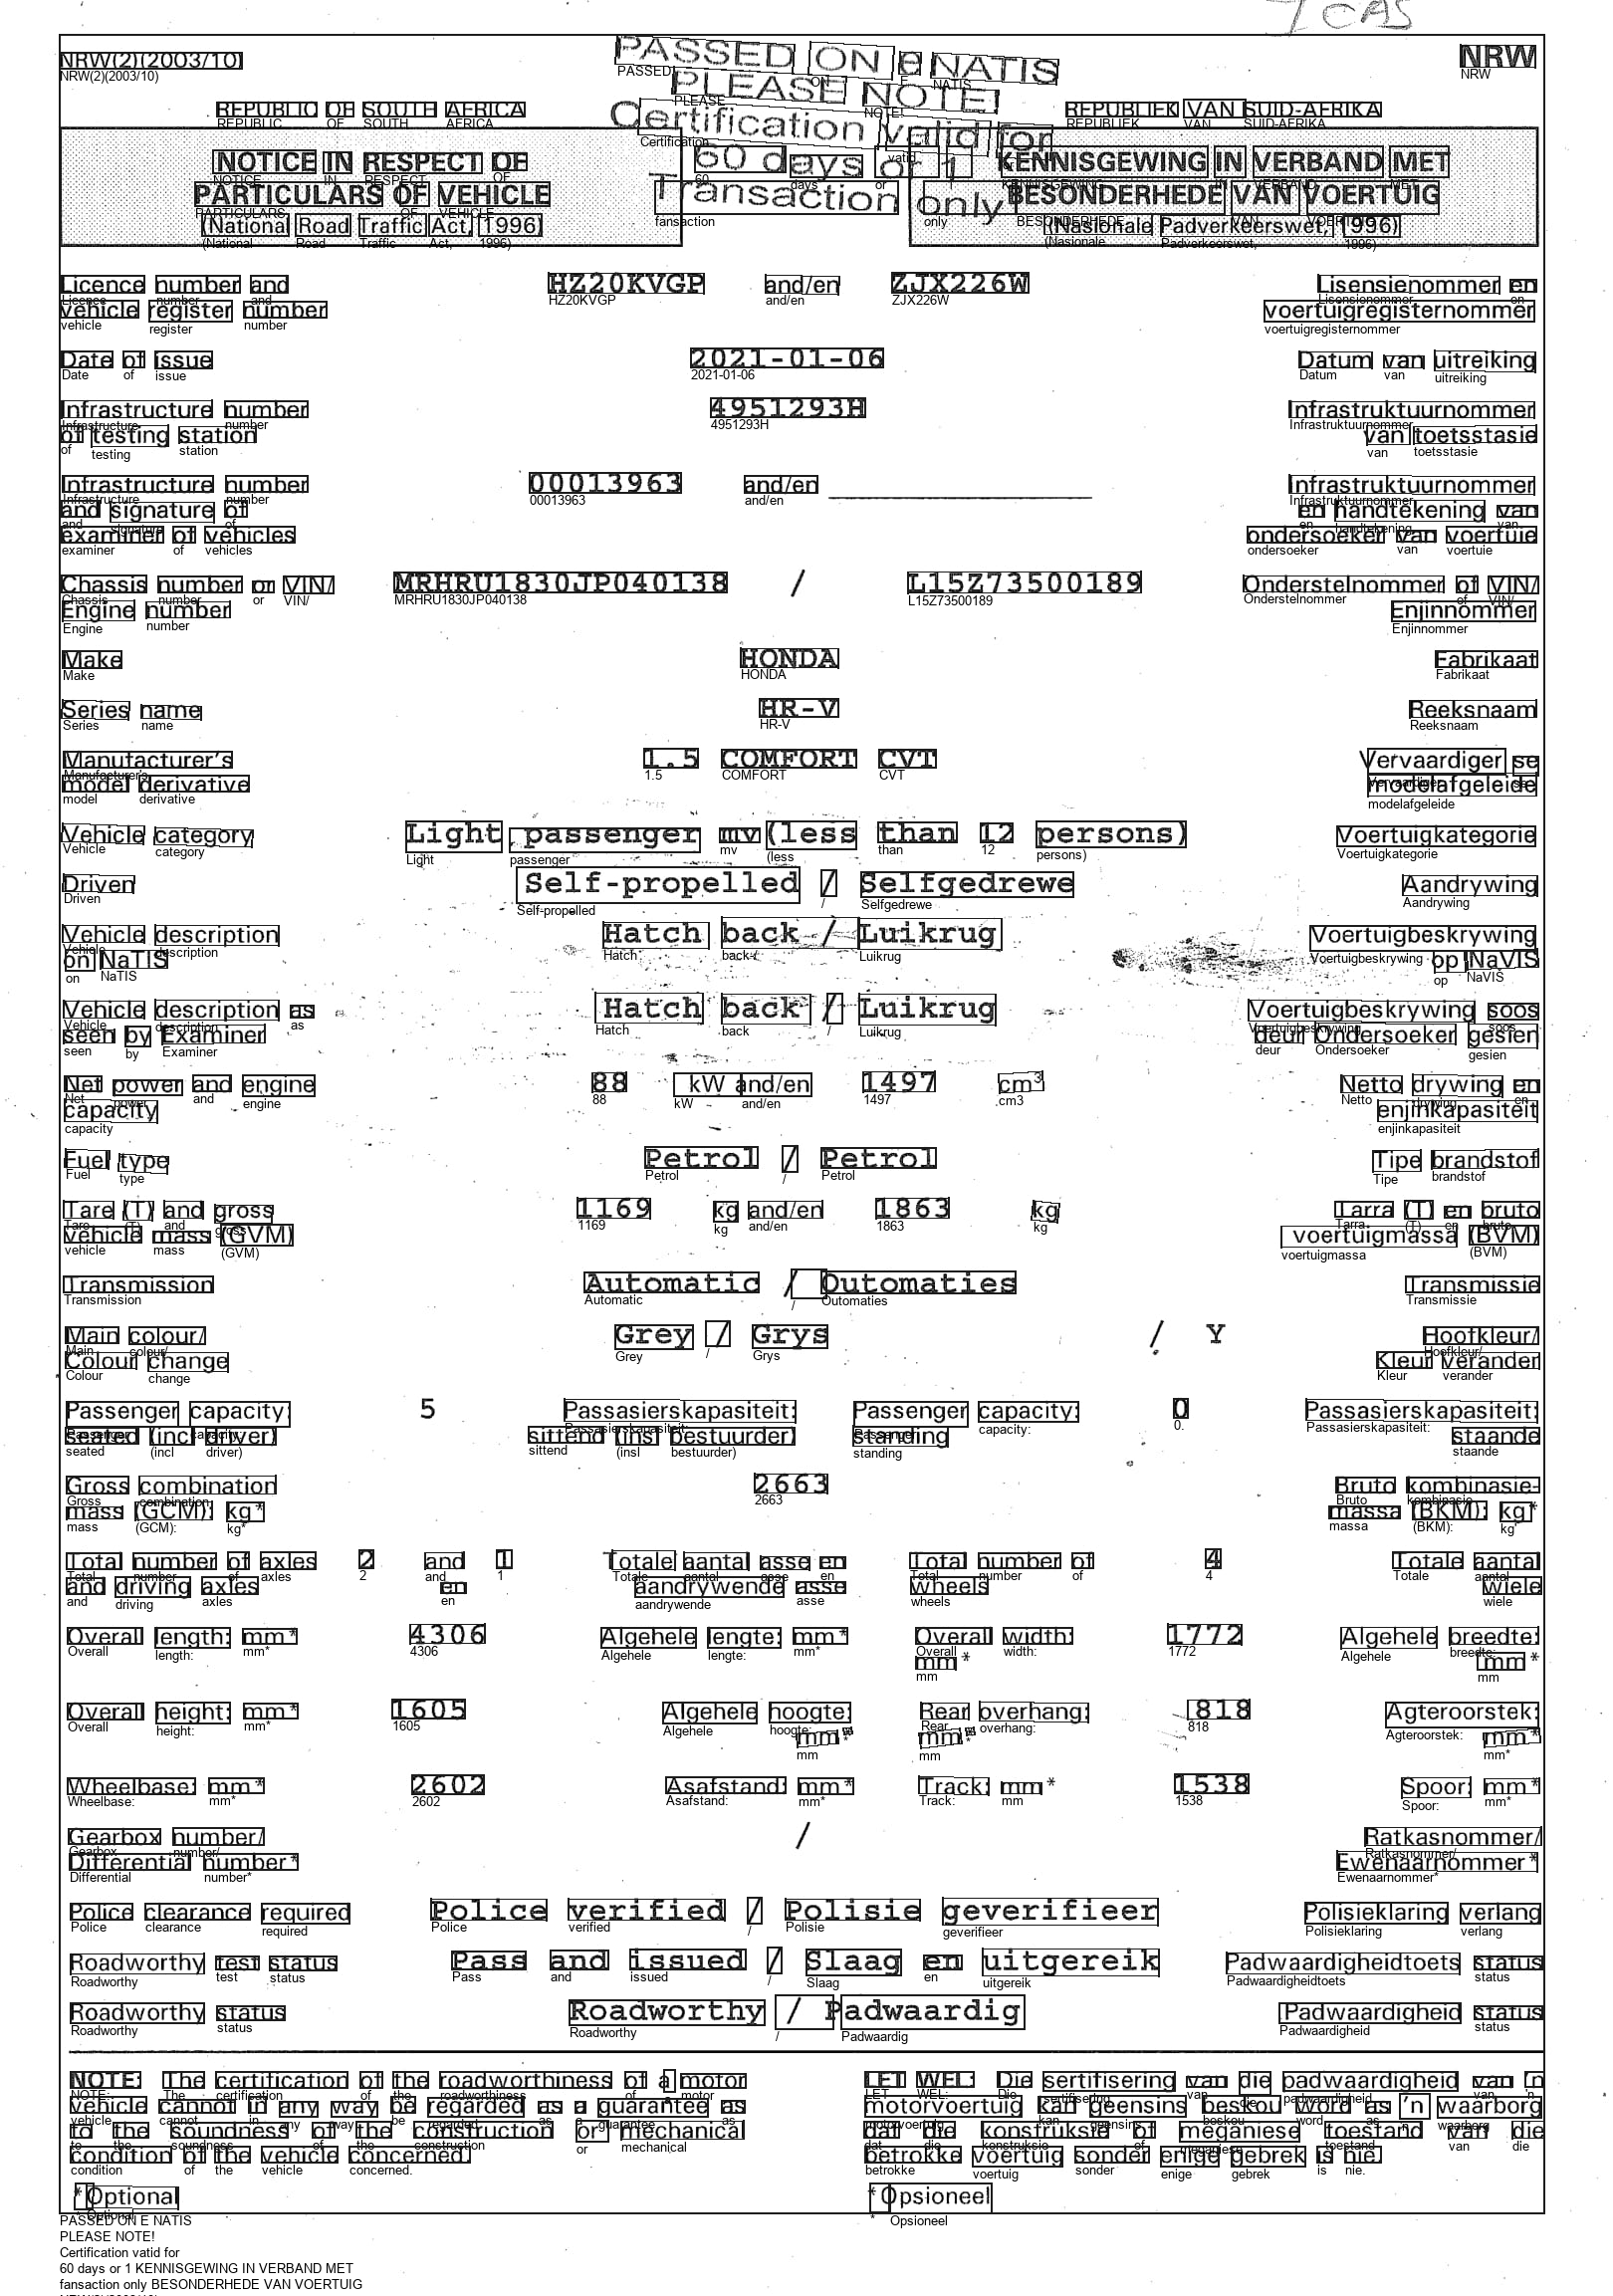

In [68]:
import os, io
from google.cloud import vision_v1 as vision
from google.cloud.vision_v1 import types
from google.cloud import translate_v2 as translate
import pandas as pd
import cv2
import numpy as np
import json
import re
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from enum import Enum
from termcolor import colored
from itertools import groupby
import statistics
%matplotlib inline


os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r'Demz_vision_API_token.json' # google API credentials

# # Path to the rc1
# rc1_1 = 'rc1-1.jpg'
# rc1_2 = 'rc1-2.jpg'
# FOLDER_PATH = 'C:\\Users\\USER\\Desktop\\NEW_DEMZ\\OCR\OCR_Works\\Google\\rc1\\images'

# Path to the rc1
nrw_1 = 'nrw-1.jpg'
nrw_2 = 'nrw-2.jpg'
nrw_3 = 'nrw-3.jpg'
FOLDER_PATH = 'C:\\Users\\USER\\Desktop\\NEW_DEMZ\\OCR\OCR_Works\\Google\\nrw\\images'

image = nrw_1

# Google API client
client = vision.ImageAnnotatorClient()

# Open and Read contents on the documents
with io.open(os.path.join(FOLDER_PATH, image), 'rb') as image_file1:
        content = image_file1.read()
content_image = types.Image(content=content) # Reading the Image Content
rc1_response = client.text_detection(image=content_image) # Text Detection 
rc1_texts = rc1_response.text_annotations # Text Response

# face detection
response_face = client.face_detection(image=content_image)
faceAnnotations = response_face.face_annotations


def draw_boxes(image, bounds,faceAnnotations, color,width=2):
    """This functionality draws bounding box on the detected texts and around the faces if any"""
    image = Image.open(image)
#     image = resize_Image(img)
    draw = ImageDraw.Draw(image)
    for text in bounds:
        draw.line([
            text.bounding_poly.vertices[0].x, text.bounding_poly.vertices[0].y, # left
            text.bounding_poly.vertices[1].x, text.bounding_poly.vertices[1].y, # top
            text.bounding_poly.vertices[2].x, text.bounding_poly.vertices[2].y, # right
            text.bounding_poly.vertices[3].x, text.bounding_poly.vertices[3].y, # bootom
            text.bounding_poly.vertices[0].x, text.bounding_poly.vertices[0].y],fill=color, width=width)
        txt=text.description
        size = 13
        font=ImageFont.truetype("fonts/arial.ttf",size)
        
        draw.text((text.bounding_poly.vertices[0].x, text.bounding_poly.vertices[3].y), txt, font=font, fill="#000")
    try: # check if face or passport is in the document
        for face in faceAnnotations:
            draw.line([
                face.bounding_poly.vertices[0].x, face.bounding_poly.vertices[0].y,
                face.bounding_poly.vertices[1].x, face.bounding_poly.vertices[1].y,
                face.bounding_poly.vertices[2].x, face.bounding_poly.vertices[2].y,
                face.bounding_poly.vertices[3].x, face.bounding_poly.vertices[3].y,
                face.bounding_poly.vertices[0].x, face.bounding_poly.vertices[0].y],fill='yellow', width=width)
            txt='Face'
            size = 13
            font=ImageFont.truetype("fonts/arial.ttf",size)
            draw.text((face.bounding_poly.vertices[0].x, face.bounding_poly.vertices[3].y), txt, font=font, fill="#000")
    except:
        pass
    return image

draw_boxes(os.path.join(FOLDER_PATH, image),rc1_texts, faceAnnotations, 'blue')


# Crop out faces if any

In [69]:
# Get crop hint
crop_hints_params = vision.CropHintsParams(aspect_ratios=[1.77])
def get_crop_hint(crop_hints):
    """Detect crop hints on a single image and return the first result."""
    with io.open(crop_hints, 'rb') as image_file1:
        content = image_file1.read()

    # content = crop_hints
    image = vision.Image(content=content)

    image_context = vision.ImageContext(crop_hints_params=crop_hints_params)

    response = client.crop_hints(image=image, image_context=image_context)
    hints = response.crop_hints_annotation.crop_hints

    # Get bounds for the first crop hint using an aspect ratio of 1.77.
    vertices = hints[0].bounding_poly.vertices

    return vertices

def crop_Face_hint(image_file, faceAnnotations):
    """Crop the image using the hints in the vector list."""
    vects = get_crop_hint(image_file)
    faceAnnotations = faceAnnotations
    try:
        face_bounds = []
        for face in faceAnnotations:
            face_vertices = (['({0},{1})'.format(vertex.x, vertex.y) for vertex in face.bounding_poly.vertices])
            face_bounds.append(face_vertices)
        bound_1 = face_bounds[0][0]
        bound_2 = face_bounds[0][2]
        bound_1 = eval(bound_1)
        bound_2 = eval(bound_2)

        im = Image.open(image_file)

        im2 = im.crop([bound_1[0], bound_1[1],
                      bound_2[0] - 1, bound_2[1] - 1])
        return im2
    except:
        print("No Image Detected")
    
face = crop_Face_hint(os.path.join(FOLDER_PATH, image), faceAnnotations)
face

No Image Detected


# Parse and Extract the document

In [70]:
def arrange_the_texts(rc1_response):

    # rearrange the Response using the bbox values
    items = []
    lines = {}

    for text in rc1_response.text_annotations[1:]:
        left_x_axis = text.bounding_poly.vertices[0].x # top left
        left_y_axis = text.bounding_poly.vertices[0].y # top left
        top_x_axis = text.bounding_poly.vertices[1].x # top
        top_y_axis = text.bounding_poly.vertices[1].y # top
        right_x_axis = text.bounding_poly.vertices[2].x # right
        right_y_axis = text.bounding_poly.vertices[2].y # right
        bottom_x_axis = text.bounding_poly.vertices[3].x # bottom
        bottom_y_axis = text.bounding_poly.vertices[3].y # bottom

        if left_y_axis not in lines:
            lines[left_y_axis] = [(left_y_axis, bottom_y_axis), []]
        for s_top_y_axis, s_item in lines.items():
            if left_y_axis < s_item[0][1]:
                lines[s_top_y_axis][1].append(([left_x_axis, bottom_y_axis, top_x_axis], text.description))
                break
    for _, item in lines.items():
        if item[1]:
            words = sorted(item[1], key=lambda t: t[0])
            items.append((item[0], ' '.join([word for _, word in words]), words))

    # print(items)

    # Find the most common space
    def find_common_space(items):
        spaces = []
        for i,k in enumerate(items):
            try:
                calculated_space = items[i][2][0][0][1] - items[i -1][2][0][0][1]
                spaces.append(calculated_space)
            except:
                ...

        common_space = abs(statistics.median(spaces))

        return common_space

    print(find_common_space(items))
    # print(len(items))

    # Split the content based on horizontal space
    new_content = []

    most_common_space = find_common_space(items)
    print(most_common_space)

    len_content = len(items) / 5.5

    for i,k in enumerate(items):
        try:
            if abs(items[i][2][0][0][1] - items[i -1][2][0][0][1]) >= most_common_space -len_content:
                new_content.append([])
                new_content.append(items[i][2])
            else:
                new_content.append(items[i][2])
        except:
            new_content.append(items[i][2])


    # group the contents based on horizontal space
    new_content = [list(l) for i, l in groupby(new_content, bool) if i]

    # join list that the length is greater than one
    for i in range(len(new_content)):
        if len(new_content[i]) > 1:
            new_content[i] = sum(new_content[i], [])
            new_content[i] = [new_content[i]]
        else:
            new_content[i] = new_content[i]

    # find common width of white space on the document
    def find_common_diff(content):
        diffs = []
        for i,j in enumerate(new_content):
            for u,t in enumerate(new_content[i][0]):
                try:
                    difference = abs(new_content[i][0][u][0][2] - new_content[i][0][u-1][0][0])
                    diffs.append(difference)
                except:
                    ...
        common_diffs = abs(statistics.median(diffs))
        return common_diffs

    # print(find_common_diff(new_content))

    # find common width of white space on a line
    def find_common_diff_in_line(content):
        diffs = []
        for i,j in enumerate(new_content):
            temp_diffs = []
            for u,t in enumerate(new_content[i][0]):
                try:
                    difference = abs(new_content[i][0][u][0][0] - new_content[i][0][u-1][0][2])
                    temp_diffs.append(difference)
                except:
                    ...
            diffs.append(temp_diffs)
        return diffs

    # print(find_common_diff_in_line(new_content))

    def check_for_max_width(new_content):
        '''Check for max with of a text in a line'''
        widths = []
        for i,j in enumerate(new_content):
            temp_diffs = []
            for u,t in enumerate(new_content[i][0]):
                try:
                    text_width = abs(new_content[i][0][u][0][0] - new_content[i][0][u][0][2])
                    temp_diffs.append(text_width)
                except:
                    ...
            widths.append(temp_diffs)
        max_width = max(widths)
        return widths
    # print(check_for_max_width(new_content))


    # split line content based on vertical spacing
    contents = []
    max_text_width = 600
    most_common_diffs = find_common_diff(new_content)

    for i,j in enumerate(new_content):
        temp_content = []
        most_common_diffs_in_a_line = abs(statistics.median(find_common_diff_in_line(new_content)[i]))
        text_width = check_for_max_width(new_content)[i]
        max_width = max(text_width)
    #     print('')
        for u,t in enumerate(new_content[i][0]):
            try:
                difference = abs(new_content[i][0][u][0][0] - new_content[i][0][u-1][0][2])
                if most_common_diffs >= most_common_diffs_in_a_line and max_width < max_text_width:
                    if difference >= most_common_diffs_in_a_line+20: # getting the min width of white space in that line
                        temp_content.append([])
                        temp_content.append(new_content[i][0][u])

                    else:
                        temp_content.append(new_content[i][0][u]) 
                elif most_common_diffs >= most_common_diffs_in_a_line and max_width > max_text_width:
                    if difference > most_common_diffs_in_a_line-15: # getting the min width of white space in that line
                        temp_content.append([])
                        temp_content.append(new_content[i][0][u])

                    else:
                        temp_content.append(new_content[i][0][u])
                else:
                    if difference > most_common_diffs-65: # getting the most common width of white space in the doc
                        temp_content.append([])
                        temp_content.append(new_content[i][0][u])

                    else:
                        temp_content.append(new_content[i][0][u])
            except:
                ...
    #     print(temp_content)
        new_temp_content = [list(l) for i, l in groupby(temp_content, bool) if i]
        contents.append(new_temp_content)    
    #     contents.append(temp_content)
    return contents

In [71]:
def extract_keys_and_values(contents):
    """ This functionality extracts they keys and values as in the document structure"""
    def check_for_non_english(new_content):
        """this function Counts the number of non-english and english texts in a line"""
        max_pos = 800 # this is the max starting position that an english word does exceed
        translate_client = translate.Client()
        target = 'en'
        detected_words = []
        for i,j in enumerate(new_content):
            temp_words = []
            for u,t in enumerate(new_content[i]):
                counts = {'en':0, 'af':0}
                left_bbox = contents[i][u][0][0][0]
                for s,r in enumerate(new_content[i][u]):
                    try:
                        text = new_content[i][u][s][1]
                        output = translate_client.translate(text, target_language=target)
                        if output['detectedSourceLanguage'] == 'en' or left_bbox < max_pos:
                            counts['en'] += 1
                        else:
                            counts['af'] += 1
                    except:
                        ...
                temp_words.append(counts)
            detected_words.append(temp_words)
        return detected_words

    word_detection = check_for_non_english(contents)

    new_contents = []
    max_position = 1200
    list_of_special_keywords = ['RC1', 'RNC', 'RTS', 'NRW'] # special key words to add to the extracted values

    for i,j in enumerate(contents): # 
        temp_content = []
        word_detected = word_detection[i]
        content = contents[i]
        for u,t in enumerate(contents[i]):
            left_bbox = contents[i][u][0][0][0]
            if word_detected[u]['en'] > word_detected[u]['af'] and left_bbox < max_position or contents[i][u][0][1] in list_of_special_keywords:
                temp_content.append(content[u])
        new_contents.append(temp_content)

    # get the left bbox of the keys
    left_bbox_lists = []
    for i in range(len(new_contents)):
        try:
            left_bbox = new_contents[i][0][0][0][0]
            left_bbox_lists.append(left_bbox)
        except:
            left_bbox = 0
            left_bbox_lists.append(left_bbox)
    print(left_bbox_lists)
    max_left_bbox = max(left_bbox_lists)


    # getting the keys and values 
    # getting the keys and values 
    rc1_contents = []
    max_starting_pos = 250

    for i in range(len(new_contents)):
        keys = ''
        values = ''
        for u in range(len(new_contents[i])):
            left_bbox = new_contents[i][u][0][0][0]
            if left_bbox <= max_left_bbox and left_bbox <=max_starting_pos:
                try:
                    for j in range(len(new_contents[i][u])):
                        text = new_contents[i][u][j][1]
                        keys += ' '+text
                except:
                    ...
            else:
                try:
                    for j in range(len(new_contents[i][u])):
                        text = new_contents[i][u][j][1]
                        values += ' '+text
                except:
                    ...
        # if the content of the current line does not have a key but has a value. 
        # if so join the value with the value of the previous item in the rc1_contents.
        # Also check if the current key started with uppercase and the next key started wih lowercase
        # if so merge the current key with the next key
        last_key =  ''
        last_value = ''
        try:
            last_key = [i for i,j in rc1_contents[-1].items()][0] # previous item key
            last_value = [j for i,j in rc1_contents[-1].items()][0] # previous item value
        except:
            ...

        if keys == '' and values != '' and last_key and last_value:   # check for condition
            k = '' 
            val = ''
            for key, value in rc1_contents[-1].items():
                if key and value:
                    val = value 
                    val += ' '+values
                    k = key
    #                 print(key, value)
                else:
                    k = key
                    val = value
            rc1_contents.remove(rc1_contents[-1])
            rc1_contents.append({k:val})
        elif last_key != '' and keys != '':
            if last_key.strip()[0].isupper() and (keys.strip()[0].islower() and not values):
                k = '' 
                val = ''
                for key, value in rc1_contents[-1].items():
                    if key and value:
                        val = value 
                        k = key
                        k += ' '+keys
        #                 print(key, value)
                    else:
                        k = key
                        val = value
                rc1_contents.remove(rc1_contents[-1])
                rc1_contents.append({k:val})
            else:
                rc1_contents.append({keys:values})

        else:
            rc1_contents.append({keys:values})
    return rc1_contents




In [72]:
contents = arrange_the_texts(rc1_response)
contents = extract_keys_and_values(contents)

40.0
40.0
[60, 214, 196, 0, 62, 62, 62, 63, 62, 63, 63, 64, 63, 64, 63, 64, 65, 65, 66, 64, 64, 66, 67, 67, 67, 68, 68, 68, 69, 71, 71, 71, 71, 76]


In [73]:
for i in contents:
    print(i)

{' NRW(2)(2003/10)': ' PASSED ON E NATIS NRW PLEASE NOTE! REPUBLIC OF SOUTH AFRICA Certification'}
{' NOTICE': ' 60 IN RESPECT OF days'}
{' PARTICULARS (National Road Traffic OF Act, VEHICLE': ' 1996) fansaction only BESONDERHEDE'}
{'': ''}
{' Licence number and vehicle register number': ' HZ20KVGP and/en ZJX226W'}
{' Date of issue': ' 2021-01-06'}
{' Infrastructure number of testing station': ' 4951293H'}
{' Infrastructure number and signature of examiner of vehicles': ' 00013963 and/en'}
{' Chassis number or VIN/ Engine number': ' MRHRU1830JP040138 L15Z73500189'}
{' Make': ' HONDA'}
{' Series name': ' HR-V'}
{" Manufacturer's model derivative": ' 1.5 COMFORT CVT'}
{' Vehicle category': ' Light passenger mv (less than 12 persons)'}
{' Driven': ' Self-propelled / Selfgedrewe'}
{' Vehicle description on NaTIS': ' Hatch back-/ Luikrug'}
{' Vehicle description as seen by Examiner': ' Hatch back / Luikrug'}
{' Net power and engine  сарacity': ' 88 kW and/en 1497'}
{' Fuel type': ' Petrol /

# Pull out specified info

In [77]:
keys_to_pull_out_RNC = ['Registering authority', 'Traffic register number', 'Name', 'Postal address', 'Street address', 'Address where notices must be served', 'Control number', 'Issue number', 'Date of issue']
keys_not_to_pull_out_RC1 = [ "4024", "at Registering which registered authority", "RET(7)(2005/02)", "Republic of South Africa" ]
keys_not_to_pull_out_NRW = ["NRW(2)(2003/10)", "NOTICE", "PARTICULARS (National Road Traffic OF Act, VEHICLE"]

keys_to_pull_out_RNC = [i.upper().strip() for i in keys_to_pull_out_RNC]
keys_not_to_pull_out_RC1 = [i.upper().strip() for i in keys_not_to_pull_out_RC1]
keys_not_to_pull_out_NRW = [i.upper().strip() for i in keys_not_to_pull_out_NRW]

extracted_values = []

# check if the special keys are in the document, if so pull the right keys
for e,f in contents[0].items():
    if 'RNC' in f:
        for i in range(len(contents)):
            for key, value in contents[i].items():
                key = ' '.join(key.split())
                if key.upper() in keys_to_pull_out_RNC:
                    extracted_values.append(contents[i])
    elif 'RC1' in f:
        for i in range(len(contents)):
            for key, value in contents[i].items():
                key = ' '.join(key.split())
                if key.upper() in keys_not_to_pull_out_RC1:
                    ...
                else:
                    if key != '':
                        extracted_values.append(contents[i])
    elif 'NRW' in f:
        for i in range(len(contents)):
            for key, value in contents[i].items():
                key = ' '.join(key.split())
                if key.upper() in keys_not_to_pull_out_NRW:
                    ...
                else:
                    if key != '':
                        extracted_values.append(contents[i])


print('')
extracted_values

[{' Licence number and vehicle register number': ' HZ20KVGP and/en ZJX226W'},
 {' Date of issue': ' 2021-01-06'},
 {' Infrastructure number of testing station': ' 4951293H'},
 {' Infrastructure number and signature of examiner of vehicles': ' 00013963 and/en'},
 {' Chassis number or VIN/ Engine number': ' MRHRU1830JP040138 L15Z73500189'},
 {' Make': ' HONDA'},
 {' Series name': ' HR-V'},
 {" Manufacturer's model derivative": ' 1.5 COMFORT CVT'},
 {' Vehicle category': ' Light passenger mv (less than 12 persons)'},
 {' Driven': ' Self-propelled / Selfgedrewe'},
 {' Vehicle description on NaTIS': ' Hatch back-/ Luikrug'},
 {' Vehicle description as seen by Examiner': ' Hatch back / Luikrug'},
 {' Net power and engine  сарacity': ' 88 kW and/en 1497'},
 {' Fuel type': ' Petrol / Petrol'},
 {' Tare (T) and gross vehicle mass (GVM)': ' 1169 kg and/en 1863 kg'},
 {' Transmission': ' Automatic / Outomaties'},
 {' Main colour/ Colour change': ' Grey / Grys'},
 {' Passenger capacity: seated (in